## IMPORT DATASET AND MODEL

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/progetto lab AI/tesi/siamunet')

Mounted at /content/drive


In [2]:
%matplotlib inline
from LEVIR_Loader import get
from siamunet_diff import SiamUnet_diff

train_loader, val_loader, test_loader = get("drive/MyDrive/progetto lab AI/LEVIR-CD+", 1)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 637 samples in drive/MyDrive/progetto lab AI/LEVIR-CD+/train
Found 129 samples in drive/MyDrive/progetto lab AI/LEVIR-CD+/val
Found 219 samples in drive/MyDrive/progetto lab AI/LEVIR-CD+/test


## PLOT SOME SAMPLES

Batch 0


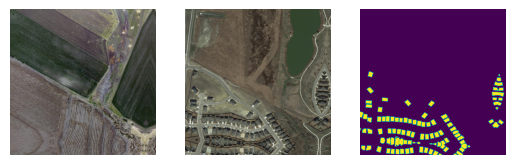

Batch 1


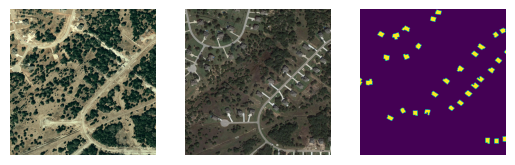

Batch 2


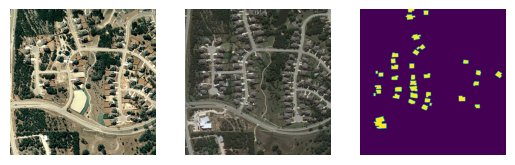

Batch 3


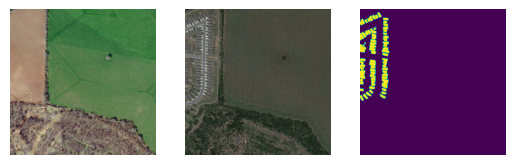

Batch 4


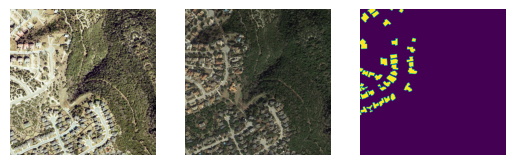

In [3]:
import matplotlib.pyplot as plt

def plot(max_plot):
    for batch_id, (images_A, images_B, images_label) in enumerate(train_loader):
        # image shapes: (1, C, H, W)
        for i in range(images_A.shape[0]):
            if i + images_A.shape[0]*batch_id + 1 > max_plot:
                return
            print("Batch", batch_id)
            image_A = images_A[i]  # Remove the batch dimension if not needed (1, C, H, W) to (C, H, W)
            image_B = images_B[i]
            image_label = images_label[i]

            plt.subplot(1, 3, 1)  # Create subplots for each image
            plt.imshow(image_A.numpy().transpose((1, 2, 0)))  # transpose is needed to go from (C, H, W) to (H, W, C)
            plt.axis('off')

            plt.subplot(1, 3, 2)
            plt.imshow(image_B.numpy().transpose((1, 2, 0)))
            plt.axis('off')

            plt.subplot(1, 3, 3)
            plt.imshow(image_label.numpy().transpose((1, 2, 0)))  # transpose is not needed because image_label is one channel only
            plt.axis('off')
            plt.show()
plot(5)

## LOAD:

In [ ]:
from torch.optim import Adam, lr_scheduler
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATH = "drive/MyDrive/progetto lab AI/tesi/siamunet/saves/save_best_f1.pt"

net = SiamUnet_diff(3, 2)
net.to(device)
opt = Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.ExponentialLR(opt, 0.95)

checkpoint = torch.load(PATH)
net.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

print("Loaded checkpoint at epoch:", epoch, ", loss:", loss)

Loaded checkpoint at epoch: 28 , loss: 0.07428627461194992


## CREATE NEW INSTANCE

In [ ]:
from torch.optim import Adam, lr_scheduler
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net = SiamUnet_diff(3, 2)
net.to(device)
opt = Adam(net.parameters(), lr=0.0001, weight_decay=1e-4)
scheduler = lr_scheduler.ExponentialLR(opt, 0.95)
epoch = 0

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.1/731.1 kB 11.1 MB/s eta 0:00:00


## TRAIN:

In [ ]:
import time
import torch
from torch.nn import NLLLoss
from torch.optim import Adam

from torchmetrics.classification import BinaryF1Score

from tqdm import tqdm

### best save
best_val_loss = 0.11835017055273056 # for the first 10 epochs
best_val_f1 = 0.19234691560268402 # for the first 10 epochs
###

lossFunc = NLLLoss()
trainSteps = 20 # train epochs to perform

metric = BinaryF1Score()
metric.to(device)

startTime = time.time()
for e in range(trainSteps): # loop over epochs
	net.train()
	totalTrainLoss = 0
	totalValLoss = 0
	totalTrain_f1 = 0
	totalVal_f1 = 0
	print("Training...")
	# train loop
	for (x, x2, y) in tqdm(train_loader):
		(x, x2, y) = (x.to(device), x2.to(device), y.to(device))

		pred = net(x, x2)
		y = torch.squeeze(y, 1).long()

		loss = lossFunc(pred, y)

		opt.zero_grad()
		loss.backward()
		opt.step()

		totalTrainLoss += loss

		disc = torch.argmax(pred, dim=1)
		totalTrain_f1 += metric(disc, y)

		del pred, loss
	print("Validating...")
	scheduler.step()

	with torch.no_grad(): # switch off autograd
		net.eval()
		# validation loop
		for (x, x2, y) in tqdm(val_loader):
			(x, x2, y) = (x.to(device), x2.to(device), y.to(device))

			pred = net(x, x2)
			y = torch.squeeze(y, 1).long()

			loss = lossFunc(pred, y)
			totalValLoss += loss

			disc = torch.argmax(pred, dim=1)
			totalVal_f1 += metric(disc, y)

	# average training and validation loss
	avgTrainLoss = totalTrainLoss / len(train_loader)
	avgValLoss = totalValLoss / len(val_loader)

	# average training and validation f1
	avgTrain_f1 = totalTrain_f1 / len(train_loader)
	avgVal_f1 = totalVal_f1 / len(val_loader)

	# save training checkpoint and losses arrays
	save(epoch+e+1, avgTrainLoss.item(), avgValLoss.item(), avgTrain_f1.item(), avgVal_f1.item())

	if avgVal_f1.item() > best_val_f1:
		saveBest_f1(epoch+e+1, avgTrainLoss.item())
		best_val_f1 = avgVal_f1.item()
	if avgValLoss.item() < best_val_loss:
		saveBest_loss(epoch+e+1, avgTrainLoss.item())
		best_val_loss = avgValLoss.item()

	print("EPOCH: {}/{}".format(epoch + e + 1, epoch + trainSteps))
	print("Train loss: {:.6f}, Test loss: {:.6f}".format(avgTrainLoss, avgValLoss))

# total training time
endTime = time.time()
print("Total time taken to train the model: {:.2f}s".format(endTime - startTime))

Training...


100%|██████████| 637/637 [01:41<00:00,  6.30it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.63it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 11 with loss 0.10946042090654373 and f1 0.3358004093170166
EPOCH: 11/30
Train loss: 0.109460, Test loss: 0.126215
Training...


100%|██████████| 637/637 [01:40<00:00,  6.32it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.60it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 12 with loss 0.10210775583982468 and f1 0.3666400909423828
EPOCH: 12/30
Train loss: 0.102108, Test loss: 0.109002
Training...


100%|██████████| 637/637 [01:40<00:00,  6.31it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.70it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 13 with loss 0.10131679475307465 and f1 0.36371174454689026
EPOCH: 13/30
Train loss: 0.101317, Test loss: 0.160632
Training...


100%|██████████| 637/637 [01:40<00:00,  6.32it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.66it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 14 with loss 0.09642013907432556 and f1 0.3925529420375824
EPOCH: 14/30
Train loss: 0.096420, Test loss: 0.129001
Training...


100%|██████████| 637/637 [01:41<00:00,  6.27it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.58it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 15 with loss 0.09239742904901505 and f1 0.40711709856987
EPOCH: 15/30
Train loss: 0.092397, Test loss: 0.118708
Training...


100%|██████████| 637/637 [01:40<00:00,  6.32it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.60it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 16 with loss 0.09062554687261581 and f1 0.42918285727500916
EPOCH: 16/30
Train loss: 0.090626, Test loss: 0.115781
Training...


100%|██████████| 637/637 [01:40<00:00,  6.32it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.65it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 17 with loss 0.08828131854534149 and f1 0.44062545895576477
EPOCH: 17/30
Train loss: 0.088281, Test loss: 0.112889
Training...


100%|██████████| 637/637 [01:41<00:00,  6.29it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.58it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 18 with loss 0.08734913170337677 and f1 0.4427342414855957
EPOCH: 18/30
Train loss: 0.087349, Test loss: 0.105342
Training...


100%|██████████| 637/637 [01:40<00:00,  6.31it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.63it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 19 with loss 0.0822623148560524 and f1 0.460907518863678
EPOCH: 19/30
Train loss: 0.082262, Test loss: 0.130727
Training...


100%|██████████| 637/637 [01:40<00:00,  6.32it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.60it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 20 with loss 0.08493221551179886 and f1 0.44722098112106323
EPOCH: 20/30
Train loss: 0.084932, Test loss: 0.103767
Training...


100%|██████████| 637/637 [01:41<00:00,  6.27it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.56it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 21 with loss 0.0818265974521637 and f1 0.4558033347129822
EPOCH: 21/30
Train loss: 0.081827, Test loss: 0.117897
Training...


100%|██████████| 637/637 [01:41<00:00,  6.30it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.64it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 22 with loss 0.08168838918209076 and f1 0.4618941843509674
EPOCH: 22/30
Train loss: 0.081688, Test loss: 0.097786
Training...


100%|██████████| 637/637 [01:40<00:00,  6.32it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.60it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 23 with loss 0.07728222757577896 and f1 0.4791492819786072
EPOCH: 23/30
Train loss: 0.077282, Test loss: 0.154160
Training...


100%|██████████| 637/637 [01:41<00:00,  6.31it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.59it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 24 with loss 0.0769377201795578 and f1 0.47270992398262024
EPOCH: 24/30
Train loss: 0.076938, Test loss: 0.106961
Training...


100%|██████████| 637/637 [01:40<00:00,  6.31it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.57it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 25 with loss 0.07720086723566055 and f1 0.4766016900539398
EPOCH: 25/30
Train loss: 0.077201, Test loss: 0.112313
Training...


100%|██████████| 637/637 [01:41<00:00,  6.31it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.58it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 26 with loss 0.07616713643074036 and f1 0.4743064045906067
EPOCH: 26/30
Train loss: 0.076167, Test loss: 0.123318
Training...


100%|██████████| 637/637 [01:41<00:00,  6.30it/s]


Validating...


100%|██████████| 129/129 [00:16<00:00,  7.62it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 27 with loss 0.07580801844596863 and f1 0.4785940647125244
EPOCH: 27/30
Train loss: 0.075808, Test loss: 0.107564
Training...


100%|██████████| 637/637 [01:41<00:00,  6.28it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.56it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 28 with loss 0.07428627461194992 and f1 0.48508888483047485
EPOCH: 28/30
Train loss: 0.074286, Test loss: 0.102275
Training...


100%|██████████| 637/637 [01:40<00:00,  6.31it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.58it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 29 with loss 0.07434318959712982 and f1 0.4888770878314972
EPOCH: 29/30
Train loss: 0.074343, Test loss: 0.124085
Training...


100%|██████████| 637/637 [01:40<00:00,  6.31it/s]


Validating...


100%|██████████| 129/129 [00:17<00:00,  7.56it/s]


train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 30 with loss 0.07351522147655487 and f1 0.4923725724220276
EPOCH: 30/30
Train loss: 0.073515, Test loss: 0.102284
Total time taken to train the model: 2363.95s


In [ ]:
save(epoch+e+1, avgTrainLoss.item(), avgValLoss.item(), avgTrain_f1.item(), avgVal_f1.item())

train losses file found
train losses file found
train f1 file found
validation f1 file found
saved succesfully at epoch 3 with loss 0.18548107147216797 and f1 0.020458916202187538


## SAVE:

In [ ]:
import numpy as np
def saveBest_f1(EPOCH, TRAIN_LOSS):
  SAVE_NAME = "save_best_f1"
  PATH = "drive/MyDrive/progetto lab AI/tesi/siamunet/saves/"

  torch.save({
              'epoch': EPOCH,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              'scheduler_state_dict': scheduler.state_dict(),
              'loss': TRAIN_LOSS,
              }, PATH + SAVE_NAME + ".pt")

def saveBest_loss(EPOCH, TRAIN_LOSS):
  SAVE_NAME = "save_best_loss"
  PATH = "drive/MyDrive/progetto lab AI/tesi/siamunet/saves/"

  torch.save({
              'epoch': EPOCH,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              'scheduler_state_dict': scheduler.state_dict(),
              'loss': TRAIN_LOSS,
              }, PATH + SAVE_NAME + ".pt")

def save(EPOCH, TRAIN_LOSS, VAL_LOSS, TRAIN_F1, VAL_F1):
  SAVE_NAME = "save"
  PATH = "drive/MyDrive/progetto lab AI/tesi/siamunet/saves/"

  torch.save({
              'epoch': EPOCH,
              'model_state_dict': net.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              'scheduler_state_dict': scheduler.state_dict(),
              'loss': TRAIN_LOSS,
              }, PATH + SAVE_NAME + ".pt")

  ## save losses
  train_losses = None
  try:
    train_losses = np.fromfile(PATH + "train_losses_" + SAVE_NAME + ".arr", dtype=float)
    print("train losses file found")
  except:
    train_losses = np.array([])
    print("train losses save not found, new one created")
  train_losses = np.append(train_losses, TRAIN_LOSS)
  train_losses.tofile(PATH + "train_losses_" + SAVE_NAME + ".arr")

  val_losses = None
  try:
    val_losses = np.fromfile(PATH + "val_losses_" + SAVE_NAME + ".arr", dtype=float)
    print("train losses file found")
  except:
    val_losses = np.array([])
    print("validation losses save not found, new one created")
  val_losses = np.append(val_losses, VAL_LOSS)
  val_losses.tofile(PATH + "val_losses_" + SAVE_NAME + ".arr")

  ## save f1 scores
  train_f1 = None
  try:
    train_f1 = np.fromfile(PATH + "train_f1_" + SAVE_NAME + ".arr", dtype=float)
    print("train f1 file found")
  except:
    train_f1 = np.array([])
    print("train f1 save not found, new one created")
  train_f1 = np.append(train_f1, TRAIN_F1)
  train_f1.tofile(PATH + "train_f1_" + SAVE_NAME + ".arr")

  val_f1 = None
  try:
    val_f1 = np.fromfile(PATH + "val_f1_" + SAVE_NAME + ".arr", dtype=float)
    print("validation f1 file found")
  except:
    val_f1 = np.array([])
    print("validation f1 save not found, new one created")
  val_f1 = np.append(val_f1, VAL_F1)
  val_f1.tofile(PATH + "val_f1_" + SAVE_NAME + ".arr")

  print("saved succesfully at epoch", EPOCH, "with loss", TRAIN_LOSS, "and f1", TRAIN_F1)

## TEST

In [ ]:
import matplotlib.pyplot as plt

for batch_id, (images_A, images_B, images_label) in enumerate(val_loader):
    # image shapes: (2, C, H, W)]

    out = net(images_A.cuda(), images_B.cuda())

    for i in range(images_A.shape[0]):
        image_A = images_A[i]  # Remove the batch dimension if not needed (1, C, H, W) to (C, H, W)
        image_B = images_B[i]
        image_label = images_label[i]

        before = plt.subplot(2, 3, 1)  # Create subplots for each image
        before.title.set_text("Before:")
        plt.imshow(image_A.numpy().transpose((1, 2, 0)))  # transpose is needed to go from (C, H, W) to (H, W, C)
        plt.axis('off')

        after = plt.subplot(2, 3, 2)
        after.title.set_text("After:")
        plt.imshow(image_B.numpy().transpose((1, 2, 0)))
        plt.axis('off')

        exp_fig = plt.subplot(2, 3, 3)
        exp_fig.title.set_text("Expected:")
        plt.imshow(image_label.numpy().transpose((1, 2, 0)))  # transpose is not needed because image_label is one channel only
        plt.axis('off')

        pred_nd = plt.subplot(2, 3, 4)
        pred_nd.title.set_text("Predicted (not discretized):")
        i = out[i][1].unsqueeze(1).cpu().detach().numpy().transpose((0, 2, 1))
        plt.imshow(i)  # transpose is needed to go from (C, H, W) to (H, W, C)
        plt.axis('off')


        discretize = True
        if discretize:
            pref_fig = plt.subplot(2, 3, 6)
            pref_fig.title.set_text("Predicted (discretized):")
            disc_img = torch.argmax(out, dim=1).float().cpu().detach().numpy()
            plt.imshow(disc_img.transpose((1, 2, 0)))  # transpose is needed to go from (C, H, W) to (H, W, C)
            plt.axis('off')

        plt.show()

Output hidden; open in https://colab.research.google.com to view.

## PLOT LOSSES

train losses file found
best val loss 0.0977860614657402
val losses file found
train f1 file found
best val f1 0.36777395009994507
val f1 file found


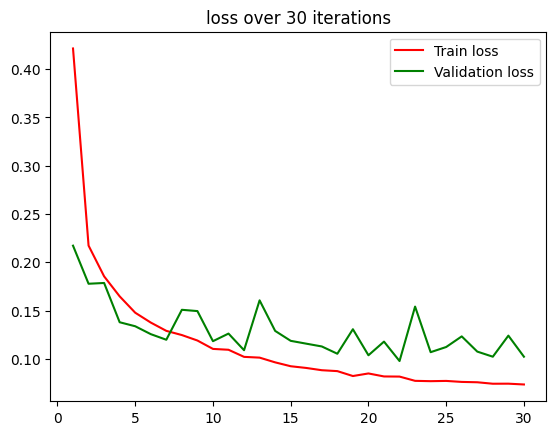

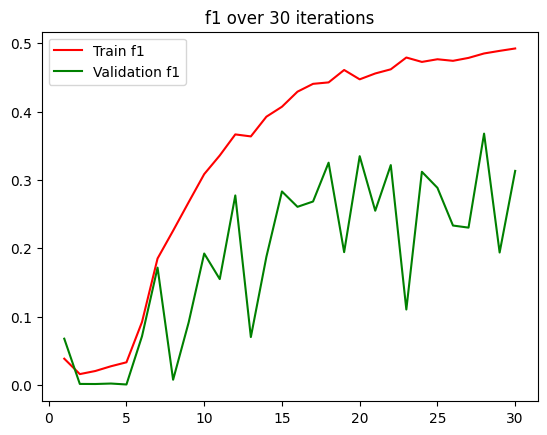

Best epoch for validation loss: 22
Best epoch for validation f1: 28


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SAVE_NAME = "save"

PATH = "drive/MyDrive/progetto lab AI/tesi/siamunet/saves/"

train_losses = None
try:
  train_losses = np.fromfile(PATH + "train_losses_" + SAVE_NAME + ".arr", dtype=float)
  print("train losses file found")
except:
  train_losses = np.array([])
  print("train losses save not found, new one created")

val_losses = None
try:
  val_losses = np.fromfile(PATH + "val_losses_" + SAVE_NAME + ".arr", dtype=float)
  print("best val loss", np.amin(val_losses))
  print("val losses file found")
except:
  val_losses = np.array([])
  print("validation losses save not found, new one created")


train_f1 = None
try:
  train_f1 = np.fromfile(PATH + "train_f1_" + SAVE_NAME + ".arr", dtype=float)
  print("train f1 file found")
except:
  train_f1 = np.array([])
  print("train f1 save not found, new one created")

val_f1 = None
try:
  val_f1 = np.fromfile(PATH + "val_f1_" + SAVE_NAME + ".arr", dtype=float)
  print("best val f1", np.amax(val_f1))
  print("val f1 file found")
except:
  val_f1 = np.array([])
  print("val f1 save not found, new one created")


def plot(TRAIN_ARR, VAL_ARR, type):
  assert len(TRAIN_ARR) == len(VAL_ARR)
  x = [i+1 for i in range(len(TRAIN_ARR))]
  plt.title(type + " over " + str(len(TRAIN_ARR)) + " iterations")
  plt.plot(x, TRAIN_ARR, color="red", label="Train " + type)
  plt.plot(x, VAL_ARR, color="green", label="Validation " + type)
  plt.legend()

  plt.show()

plot(train_losses, val_losses, "loss")
plot(train_f1, val_f1, "f1")

best = None
best_epoch = 0
for i in range(len(val_losses)):
  if best is None or val_losses[i] < best:
    best = val_losses[i]
    best_epoch = i + 1
print("Best epoch for validation loss:", best_epoch)

best = None
for i in range(len(val_f1)):
  if best is None or val_f1[i] > best:
    best = val_f1[i]
    best_epoch = i + 1
print("Best epoch for validation f1:", best_epoch)